In [1]:
def cosamp(phi, u, s, epsilon=1e-10, max_iter=1000):
    """
    Return an `s`-sparse approximation of the target signal
    Input:
        - phi, sampling matrix
        - u, noisy sample vector
        - s, sparsity
    """
    a = np.zeros(phi.shape[1])
    v = u
    it = 0 # count
    halt = False
    while not halt:
        it += 1
        print("Iteration {}\r".format(it), end="")
        
        y = np.dot(np.transpose(phi), v)
        omega = np.argsort(y)[-(2*s):] # large components
        omega = np.union1d(omega, a.nonzero()[0]) # use set instead?
        phiT = phi[:, omega]
        b = np.zeros(phi.shape[1])
        # Solve Least Square
        b[omega], _, _, _ = np.linalg.lstsq(phiT, u)
        
        # Get new estimate
        b[np.argsort(b)[:-s]] = 0
        a = b
        
        # Halt criterion
        v_old = v
        v = u - np.dot(phi, a)

        halt = (np.linalg.norm(v - v_old) < epsilon) or \
            np.linalg.norm(v) < epsilon or \
            it > max_iter
        
    return a
# cosamp function is available at https://github.com/avirmaux/CoSaMP

In [2]:
def rmse(PSD1, PSD2):
    error = np.sqrt(np.mean((PSD1 - PSD2) ** 2))
    return error

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
from scipy.fftpack import dct, idct
from scipy.optimize import minimize
from scipy.signal import find_peaks
sys.path.append(os.path.join('..','addDependencies','UTILS'))

plt.rcParams['figure.figsize'] = [12, 12]
plt.rcParams.update({'font.size': 18})

In [ ]:
## Generate signal, DCT of signal

n = 4096 # points in high resolution signal
t = np.linspace(0,1,n)
p = 32 # num. random samples, for example, when set as 32, p = n/32
perm = np.floor(np.random.rand(p) * n).astype(int)
no_of_freq = 1

x = np.cos(2 * 30 * np.pi * t) 
for addfreq in range(90, 700, 60):
    
    xt = np.fft.fft(x) # Fourier transformed signal
    PSD = xt * np.conj(xt) / n # Power spectral density
    y = x[perm]
    
    Psi = dct(np.identity(n)) 
    # display(Psi)
    Theta = Psi[perm,:]       
    
    s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) 
    xrecon = idct(s)
    
    ## Plot
    time_window = np.array([0,4096])/n
    freq = np.arange(n)
    L = int(np.floor(n/2))
    
    
    fig,axs = plt.subplots(2,2)
    axs = axs.reshape(-1)
    
    axs[1].scatter(freq[:L],PSD[:L],color='k',linewidth=2)
    axs[1].set_xlim(0, 800)
    axs[1].set_ylim(0, 1200)
    
    axs[0].plot(t,x,color='k',linewidth=2)
    axs[0].plot(perm/n,y,color='r',marker='x',linewidth=0,ms=12,mew=4)
    axs[0].set_xlim(time_window[0],time_window[1])
    axs[0].set_ylim(-2, 2)
    
    axs[2].plot(t,xrecon,color='r',linewidth=2)
    axs[2].set_xlim(time_window[0],time_window[1])
    axs[2].set_ylim(-2, 2)
    
    xtrecon = np.fft.fft(xrecon,n) # computes the (fast) discrete fourier transform
    PSDrecon = xtrecon * np.conj(xtrecon)/n # Power spectrum (how much power in each freq)
    
    axs[3].plot(freq[:L],PSDrecon[:L],color='r',linewidth=2)
    axs[3].set_xlim(0, 800)
    axs[3].set_ylim(0, 1200)

    error = rmse(PSD[:L], PSDrecon[:L])
    fig.text(0.55, 0.47, "Error: " + f"{error.real:.5g}", fontsize=12, color='red')

    # plt.savefig("p_" + str(p) + "f_" + str(no_of_freq) + ".jpg", format='jpg', dpi=300)
    
    # plt.show()

    signal_peaks, signal_properties = find_peaks(np.real(PSD[:L]), height=1)
    recon_peaks, recon_properties = find_peaks(np.real(PSDrecon[:L]), height=1)

    signal_freq = freq[signal_peaks]
    recon_freq = freq[recon_peaks]

    signal_amp = signal_properties['peak_heights']
    recon_amp = recon_properties['peak_heights']

    # error = mse(PSD[:L], PSDrecon[:L])
    # print("Error: ", error.real)
    # print(signal_freq[signal_freq < 800])
    # print(signal_amp[signal_freq < 800])
    # print(recon_freq[recon_freq < 800])
    # print(recon_amp[recon_freq < 800])

    no_of_freq += 1
    x += np.cos(2 * addfreq * np.pi * t)

In [41]:
def PSD_reconstruct_signal(p):
    ## Generate signal, DCT of signal

    n = 4096 # points in high resolution signal
    t = np.linspace(0,1,n)
    #p = 32 # num. random samples, for example, when set as 32, p = n/32
    perm = np.floor(np.random.rand(p) * n).astype(int)
    no_of_freq = 1
    errors_reg = []
    errors_sub = []

    x = np.cos(2 * 30 * np.pi * t) # signal

    # for regular nyquist sampling
    p_uniform = 2000 # double the highest signal frequency
    indices = np.linspace(0, n - 1, p_uniform, dtype=int)
    x_nyquist_samples = x[indices]
    
    for addfreq in range(90, 700, 60):
        # psd of original signal
        xt = np.fft.fft(x) # Fourier transformed signal
        PSD = xt * np.conj(xt) / n # Power spectral density

        # regular nyquist
        # Simulate normal sampling by selecting p DCT coefficients directly
        x_dct = dct(x_nyquist_samples, norm='ortho')
        x_recon_reg = idct(x_dct, norm='ortho')

        xt_recon_reg = np.fft.fft(x_recon_reg,n)
        PSD_recon_reg = xt_recon_reg * np.conj(xt_recon_reg)/n

        # sub-nyquist
        y = x[perm]
        
        Psi = dct(np.identity(n)) 
        # display(Psi)
        Theta = Psi[perm,:]
        
        s = cosamp(Theta,y,10,epsilon=1.e-10,max_iter=10) 
        x_recon_sub = idct(s)

        xt_recon_sub = np.fft.fft(x_recon_sub,n) # computes the (fast) discrete fourier transform
        PSD_recon_sub = xt_recon_sub * np.conj(xt_recon_sub)/n # Power spectrum (how much power in each freq)
        
        #calculating rmse of PSD
        L = int(np.floor(n/2))

        error_reg = rmse(PSD[:L], PSD_recon_reg[:L])
        error_sub = rmse(PSD[:L], PSD_recon_sub[:L])
        errors_reg.append(f"{error_reg.real:.5g}")
        errors_sub.append(f"{error_sub.real:.5g}")
        
        no_of_freq += 1
        x += np.cos(2 * addfreq * np.pi * t)

    return errors_reg, errors_sub

In [48]:
p = 2 ** np.arange(3, 12)
err_reg_per_p = []
err_sub_per_p = []
frequencies = np.arange(30, 631, 60)

for i in p:
    error_reg, error_sub = PSD_reconstruct_signal(i)
    err_reg_per_p.append(error_reg)
    err_sub_per_p.append(error_sub)

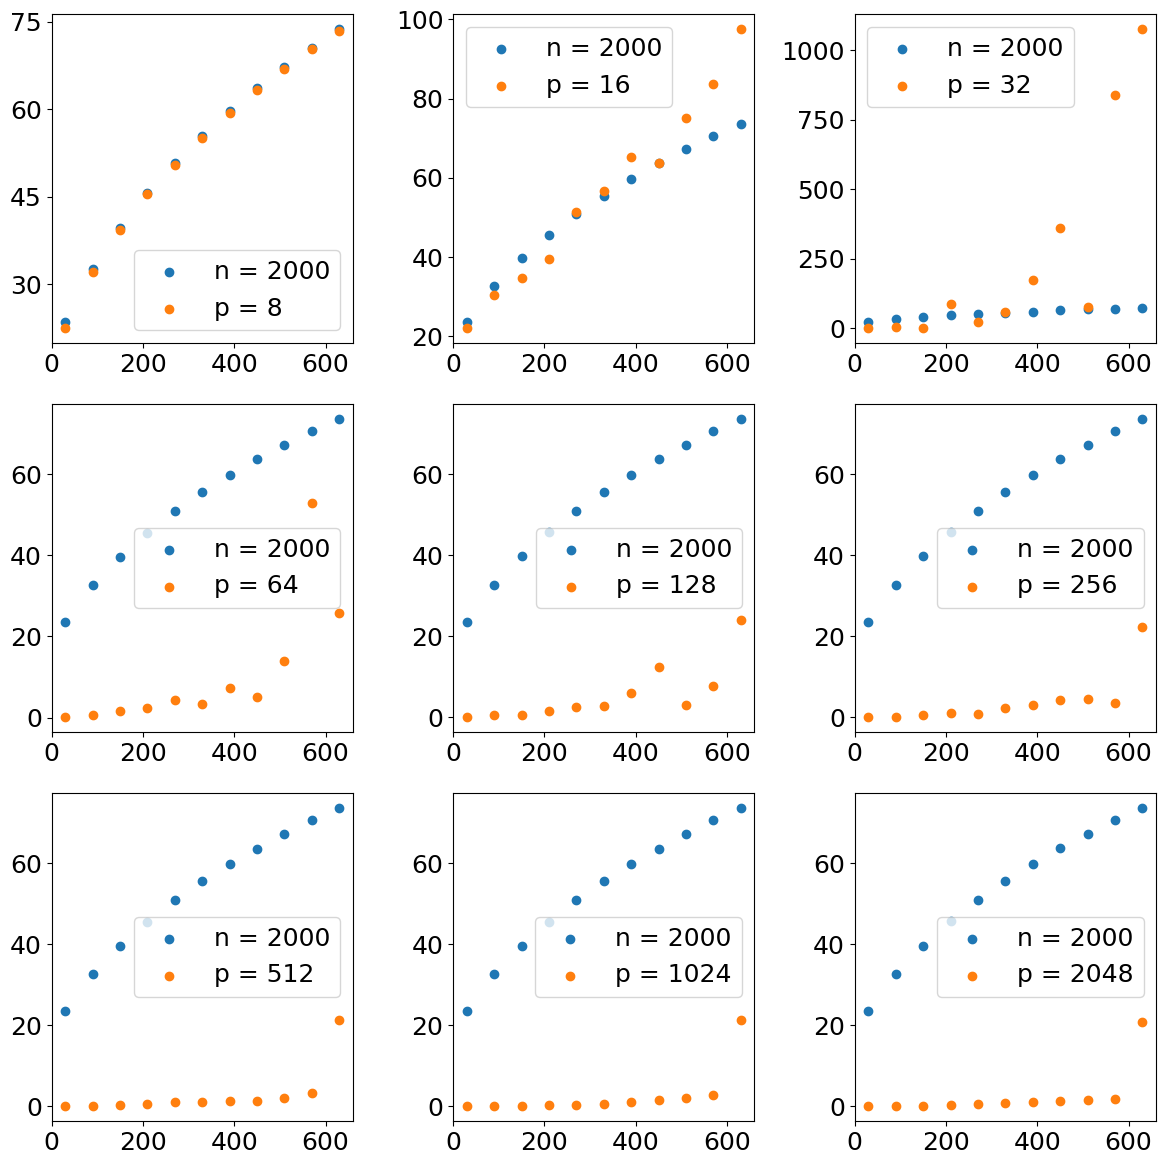

In [50]:
frequencies = np.arange(30, 631, 60)

fig1,ax1 = plt.subplots(3,3)
ax1 = ax1.reshape(-1)
# yticks = np.linspace(0, 400, num=10)

for i, error in enumerate(err_reg_per_p):
    ax1[i].scatter(frequencies,np.array(err_reg_per_p[i]).astype(float), label = "n = 2000")
    ax1[i].scatter(frequencies,np.array(err_sub_per_p[i]).astype(float), label = "p = " + str(p[i]))
    # ax1[i].set_ylim(0, 400)
    # ax1[i].set_yticks(yticks)
    ax1[i].legend()

plt.tight_layout()

for ax in ax1:
    ax.tick_params(axis='y', labelrotation=0)

for ax in ax1:
    ax.yaxis.set_major_locator(plt.MaxNLocator(nbins=5))

[ 30  90 150 210 270 330 390 450 510 570 630]
['22.848', '32.131', '39.27', '45.261', '50.502', '55.193', '59.455', '63.365', '66.976', '70.327', '73.447']
0.040866


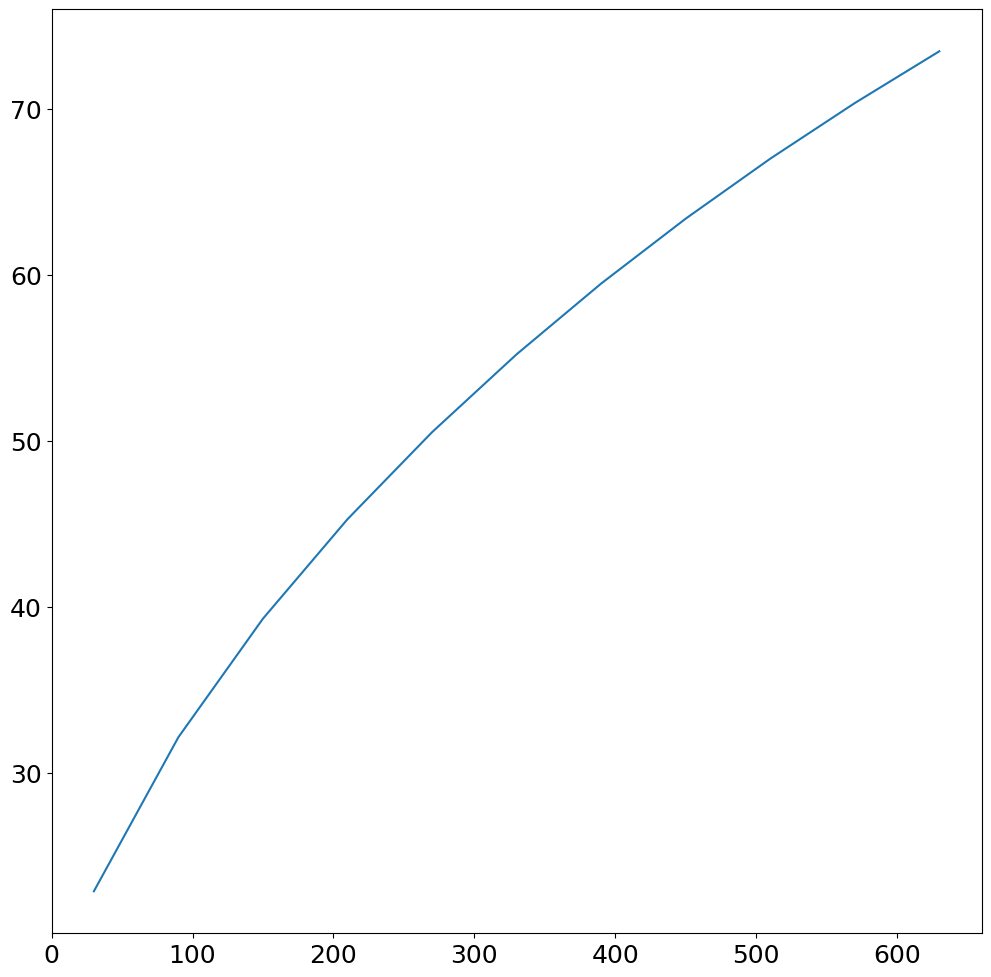

In [26]:
print(frequencies)
print(err_reg_per_p[0])
print(float(err_sub_per_p[0][0]))

float_array = np.array(err_reg_per_p[0]).astype(float)
plt.plot(frequencies,float_array)
plt.show()

In [10]:
# Basic Nyquist Sampling

n = 4096
t = np.linspace(0, 1, n)
x = np.cos(2 * 89 * np.pi * t) + np.cos(2 * 210 * np.pi * t)  # example signal

# Nyquist-rate sampling (uniform)
p_uniform = 1260
indices = np.linspace(0, n - 1, p_uniform, dtype=int)
x_nyquist_samples = x[indices]

# Create a full DCT matrix
Psi = dct(np.identity(n), norm='ortho')

# Simulate normal sampling by selecting p DCT coefficients directly
x_dct = dct(x_nyquist_samples, norm='ortho')
x_recon_nyquist = idct(x_dct, norm='ortho')  # inverse DCT

PSD_original = np.abs(np.fft.fft(x))**2 / n
PSD_recon_nyquist = np.abs(np.fft.fft(x_recon_nyquist))**2 / n

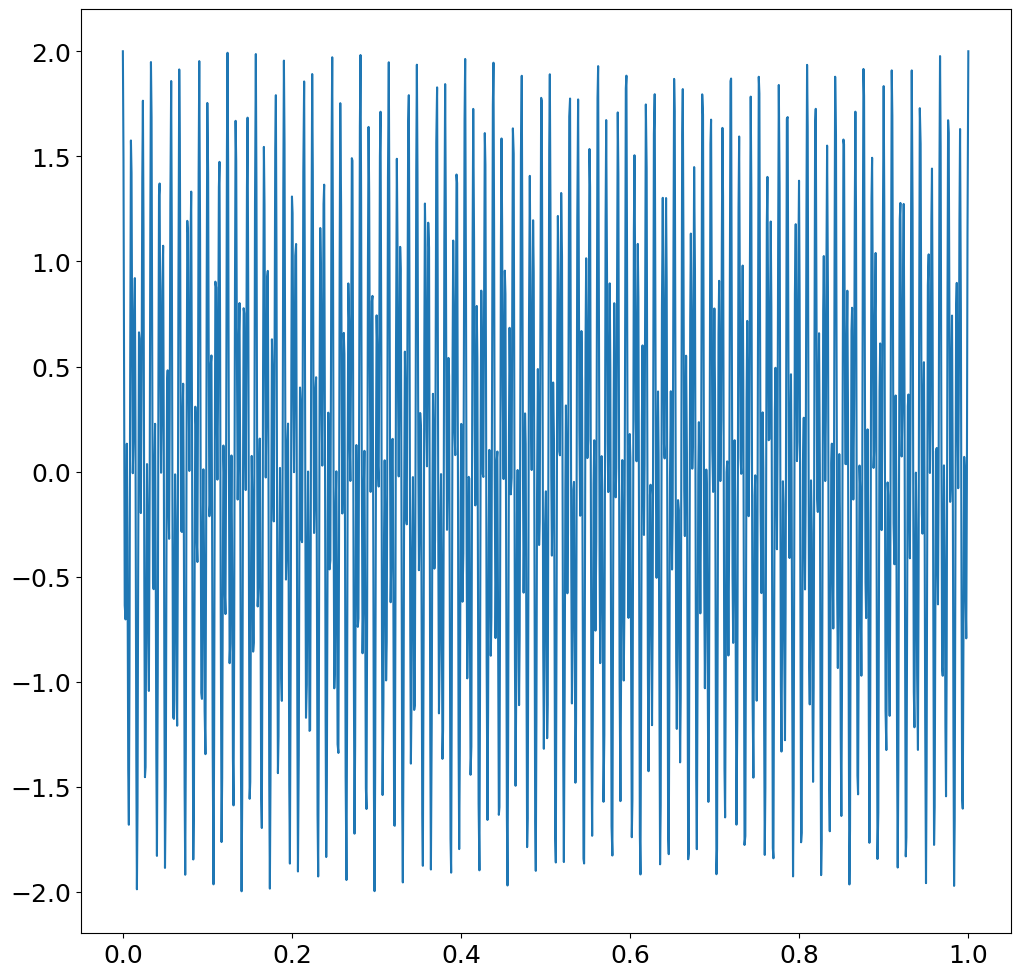

In [11]:
plt.plot(t[indices],x_recon_nyquist)

1260


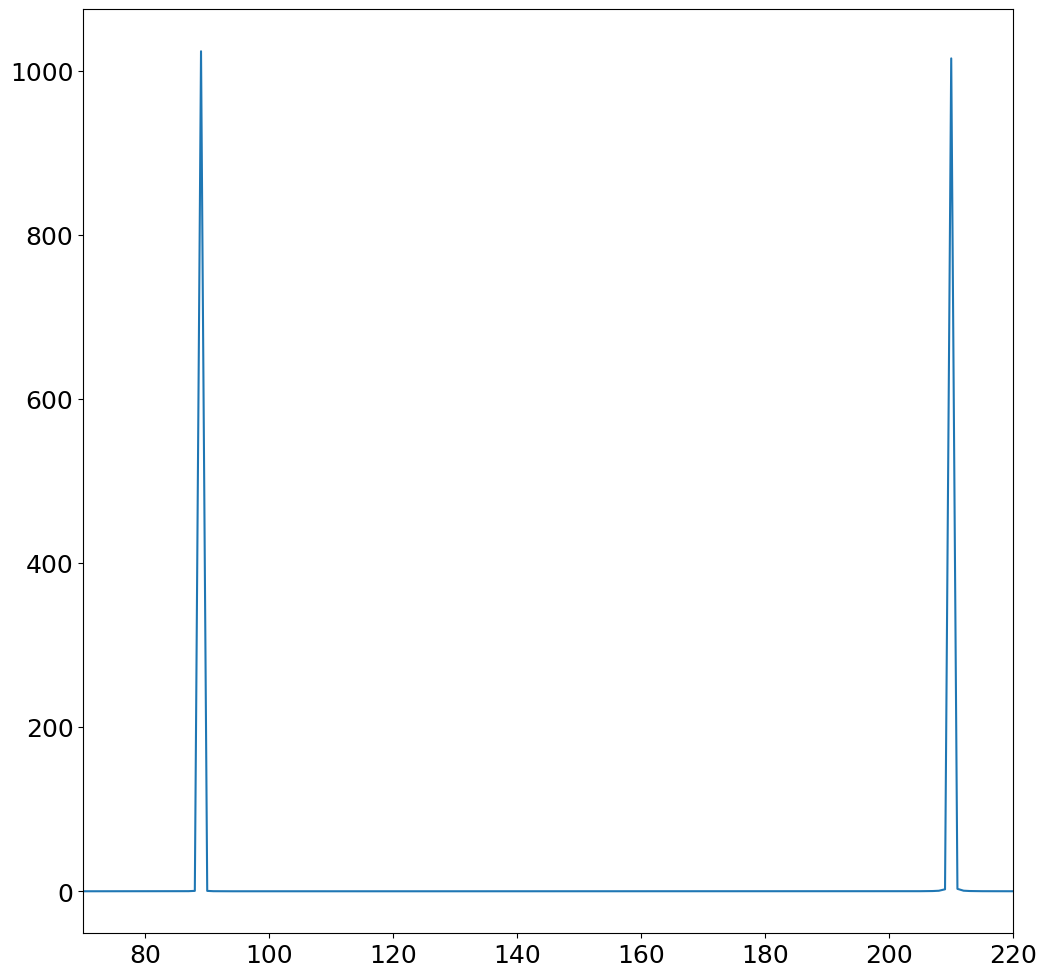

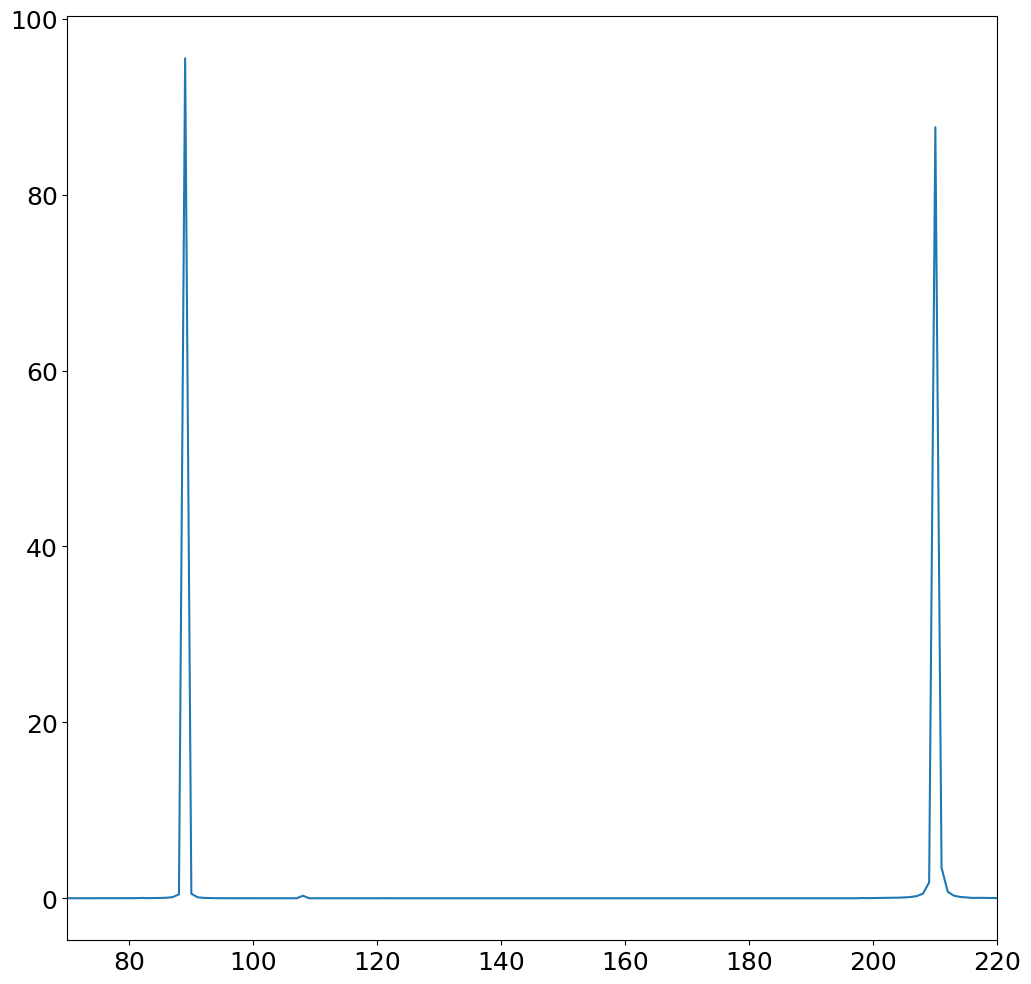

In [12]:
# print(len(PSD_original))
# print(p_uniform)
# print(indices)
print(len(indices))

plt.plot(PSD_original[:n//2])
plt.xlim(70,220)
plt.show()

# plt.plot(x)
# plt.show()

# plt.plot(x_recon_nyquist)
# plt.show()

plt.plot(PSD_recon_nyquist[:n//2])
plt.xlim(70,220)
plt.show()